In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import matplotlib.ticker as ticker
import re
import numpy as np
from IPython.display import display, HTML
sns.set_style("darkgrid")


# plot


In [228]:
def display_table_resluts(logs,columns =['type','probability','threshold','B_1','B_45','B_52'], col_to_format =  ['B_1','B_45','B_52']):
    table = logs[columns]
    for col in col_to_format:
        table[col] = table[col].apply(lambda x : '{:.2f}'.format(x))
    display(HTML(table.to_html()))
    return table

In [140]:
# def plot_bins_diff_thresholds(logs,thresholds,title,agg_type = "bins",metric = 'Acc',types = ['ssl','delay'],with_saving = False, save_table = False):
#     to_keep = ['type','probability','threshold']
#     logs = logs.sort_values(by = to_keep)
#     if agg_type == 'bins':
#         to_keep.extend([x for x in logs.columns if x.startswith("B_")])
#     elif agg_type == 'labelled instances':
#         to_keep.extend([x for x in logs.columns if x.startswith("m_")])
#     partial_logs = logs[to_keep]

#     fig, ax = plt.subplots(len(thresholds),1,figsize=(15,2*len(thresholds)), sharey=True,sharex=True)
#     fig.tight_layout()
#     for i,th in enumerate(thresholds):
#         tmp = partial_logs[partial_logs['threshold']==th]
#         tmp['type_and_probability']  = tmp['type'].astype(str)+ tmp['probability'].apply(lambda x: '_'+str(x) if  not pd.isnull(x) else "")
#         tmp = tmp.replace(" ",None)
#         tmp = tmp[tmp['type'].apply(lambda x : x in types)]
#         tmp = tmp.drop(columns=['type','probability','threshold'])
#         tmp = tmp.melt(id_vars = 'type_and_probability')
#         tmp['variable'] = tmp['variable'].apply(lambda x : x.split('_')[1])
#         if agg_type == 'labelled instances':
#             tmp['variable'] = 100*tmp['variable'].astype(int)
#         g = sns.lineplot(data = tmp, x = 'variable', y = 'value',hue = 'type_and_probability',ax = ax[i],palette='tab10')    
#         all_vars = tmp['variable'].unique()
#         all_vars =all_vars[::int(len(all_vars)/10)]
#         g.set(ylim=(0, 1),ylabel= metric,xlabel=agg_type,xticks  = all_vars)
#         ax[i].set_title(th)
#         if i>0:
#             pass
#             ax[i].legend([],[], frameon=False)
#         else:
#             sns.move_legend(ax[i], "lower center", bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=False)
#     plt.suptitle(title, size=16, y=1.2)
#     if with_saving:
#         plt.savefig(os.path.join('images',dataset,f"{title}_{agg_type}_{metric}_{'_'.join(types)}.pdf"), format="pdf", bbox_inches="tight")
#     plt.show()
#     if save_table:
#         table = display_table_resluts(logs[logs.apply(lambda x: x['type'] in types and x['threshold'] in thresholds, axis =1 )],title,agg_type,metric,types)
#         return table

In [173]:
def create_partial_plot(ax,tmp,descriptive_vars,types,agg_type,metric):
    tmp['types_of_data'] = tmp.apply(lambda r: "_".join([str(r[col]) if not pd.isna(r[col]) else "" for col in descriptive_vars ]) ,axis =1)
    tmp = tmp.replace(" ",None)
    tmp = tmp[tmp['type'].apply(lambda x : x in types)]
    tmp = tmp.drop(columns=descriptive_vars)
    tmp = tmp.melt(id_vars = 'types_of_data')
    tmp['variable'] = tmp['variable'].apply(lambda x : x.split('_')[1])
    if agg_type == 'labelled instances':
        tmp['variable'] = 100*tmp['variable'].astype(int)
    g = sns.lineplot(data = tmp, x = 'variable', y = 'value',hue = 'types_of_data',ax = ax,palette='tab10')   
    all_vars = tmp['variable'].unique()
    all_vars =all_vars[::int(len(all_vars)/10)]
    g.set(ylim=(0, 1),ylabel= metric,xlabel=agg_type,xticks  = all_vars)

In [232]:
def plot_bins_diff(logs,title,dataset, agg_type = "bins",metric = 'Acc',types = ['ssl','delay'], filter = None, descriptive_vars = [],
                    with_saving = False, save_table = False, columns_of_table = ['type','probability','B_1','B_45','B_52']):
    to_keep = [d for d in descriptive_vars]
    if filter:
        to_keep.append(filter)
    logs = logs.sort_values(by = to_keep)
    if agg_type == 'bins':
        to_keep.extend([x for x in logs.columns if x.startswith("B_")])
    elif agg_type == 'labelled instances':
        to_keep.extend([x for x in logs.columns if x.startswith("m_")])
    partial_logs = logs[to_keep]
    if filter is None:
        fig, ax = plt.subplots(1,1,figsize=(15,6), sharey=True,sharex=True)
        fig.tight_layout()
        create_partial_plot(ax,partial_logs,descriptive_vars,types,agg_type,metric)
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 0.9), ncol=4, title=None, frameon=False)
    else:
        filters = [f  for f  in partial_logs[filter].unique() if not pd.isna(f)]
        fig, ax = plt.subplots(len(filters),1,figsize=(15,2*len(filters)), sharey=True,sharex=True)
        fig.tight_layout()
        for i,f in enumerate(filters):
            tmp = partial_logs[partial_logs[filter]==f]
            tmp = tmp.drop(columns =[filter])
            create_partial_plot(ax[i],tmp,descriptive_vars,types,agg_type,metric)
            ax[i].set_title(f)
            if i>0:
                ax[i].legend([],[], frameon=False)
            else:
                sns.move_legend(ax[i], "lower center", bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=False)
        

 
    plt.suptitle(title, size=16, y=1.2)
    if with_saving:
        plt.savefig(os.path.join('images',dataset,f"{title}_{agg_type}_{metric}_{'_'.join(types)}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()
    if save_table:
        table = display_table_resluts(logs,columns =columns_of_table)
    return table

In [215]:
types = ['ssl','init']

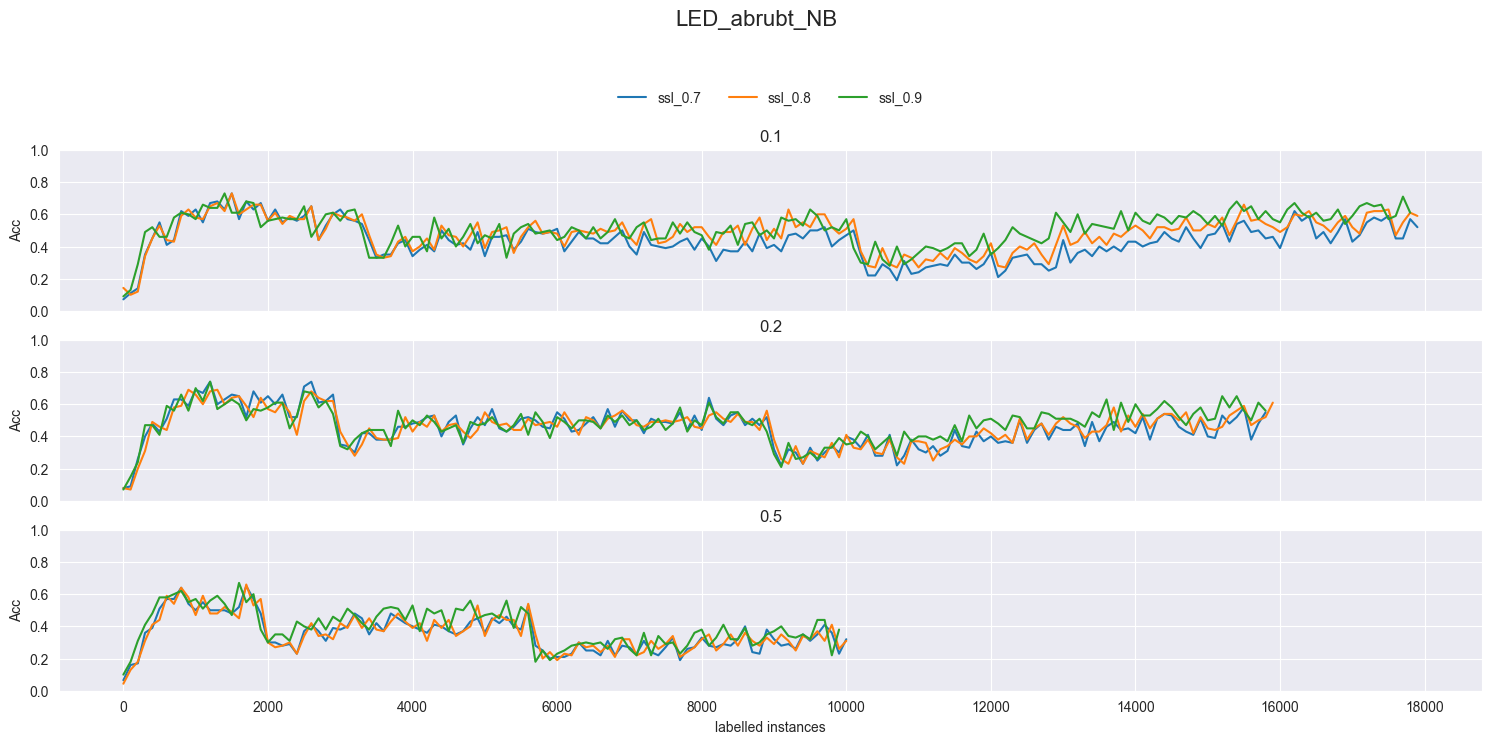

C:\Users\gosia\AppData\Local\Temp\ipykernel_34104\2491988759.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table[col] = table[col].apply(lambda x : '{:.2f}'.format(x))


,type,probability,B_1,B_45,B_52
15,delay,NaN,0.47,0.51,0.50
14,delay,NaN,0.48,0.52,0.52
12,delay,NaN,0.51,0.54,0.54
5,init,NaN,0.00,0.00,0.68
3,init,NaN,0.00,0.00,0.68
1,init,NaN,0.00,0.00,0.68
4,lfs,0.1,0.00,0.00,0.68
8,lfs,0.2,0.00,0.00,0.68
11,lfs,0.5,0.00,0.00,0.66
2,lfs,0.1,0.00,0.00,0.68


In [233]:
for dataset in ['LED_abrubt']:
    for method in ['NB']:
        logs = pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}.csv"))
        table = plot_bins_diff(logs = logs,dataset = dataset, title = f'{dataset}_{method}',agg_type = 'labelled instances',types=types, with_saving=True,save_table=True,descriptive_vars =['type','threshold'],filter='probability')
        
        

## Save to latex

In [226]:
latex_code = table.to_latex(na_rep = '')
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
latex_code = latex_code.replace("\\toprule", "")
latex_code = latex_code.replace("\\midrule", "")
latex_code = latex_code.replace("\\bottomrule", "")
print(latex_code)

\begin{tabular}{llrlll}

{} &   type &  probability &   B\_1 &  B\_45 &  B\_52 \\ \hline

15 &  delay &              &  0.47 &  0.51 &  0.50 \\ \hline
14 &  delay &              &  0.48 &  0.52 &  0.52 \\ \hline
12 &  delay &              &  0.51 &  0.54 &  0.54 \\ \hline
5  &   init &              &  0.00 &  0.00 &  0.68 \\ \hline
3  &   init &              &  0.00 &  0.00 &  0.68 \\ \hline
1  &   init &              &  0.00 &  0.00 &  0.68 \\ \hline
4  &    lfs &          0.1 &  0.00 &  0.00 &  0.68 \\ \hline
8  &    lfs &          0.2 &  0.00 &  0.00 &  0.68 \\ \hline
11 &    lfs &          0.5 &  0.00 &  0.00 &  0.66 \\ \hline
2  &    lfs &          0.1 &  0.00 &  0.00 &  0.68 \\ \hline
7  &    lfs &          0.2 &  0.00 &  0.00 &  0.68 \\ \hline
10 &    lfs &          0.5 &  0.00 &  0.00 &  0.66 \\ \hline
0  &    lfs &          0.1 &  0.00 &  0.00 &  0.68 \\ \hline
6  &    lfs &          0.2 &  0.00 &  0.00 &  0.68 \\ \hline
9  &    lfs &          0.5 &  0.00 &  0.00 &  0.66 \\ \h

C:\Users\gosia\AppData\Local\Temp\ipykernel_34104\417934100.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = table.to_latex(na_rep = '')
